In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import matplotlib.pylab as plt

In [2]:
FEATURES_INDEX = [0, 1]
LABELS_INDEX = 2
LOSS_THRESHOLD = 1e-6

In [3]:
learn_dataset = pd.read_csv('../learn_data.csv', index_col=0)
valid_dataset = pd.read_csv('../valid_data.csv', index_col=0)
test_dataset = pd.read_csv('../test_data.csv', index_col=0)
learn_dataset.head()

,0,1,2
0,0.980200,-0.735111,-0.573921
1,-1.758554,0.527610,2.068426
2,0.066156,0.404232,-0.447753
3,0.919834,-0.836112,-0.615778
4,-0.676431,-0.458955,0.800171


In [4]:
learn_dataset = np.array(learn_dataset)
valid_dataset = np.array(valid_dataset)
test_dataset = np.array(test_dataset)

In [5]:
learn_dataloader = DataLoader(learn_dataset, batch_size=len(learn_dataset), shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=len(valid_dataset), shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=len(test_dataset), shuffle=False)

In [6]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.lin1 = nn.Linear(2, 10)
        self.lin2 = nn.Linear(10, 10)
        self.lin3 = nn.Linear(10, 5)
        self.lin4 = nn.Linear(5, 1)

    def forward(self, x):
        x = F.tanh(self.lin1(x))
        x = F.tanh(self.lin2(x))
        x = F.tanh(self.lin3(x))
        x = self.lin4(x)
        return x

net = Net()
net

Net(
  (lin1): Linear(in_features=2, out_features=10, bias=True)
  (lin2): Linear(in_features=10, out_features=10, bias=True)
  (lin3): Linear(in_features=10, out_features=5, bias=True)
  (lin4): Linear(in_features=5, out_features=1, bias=True)
)

In [7]:
#Инициализация весов
STD = [(2/(2+10+1))**(1/2), (2/(10+10+1))**(1/2), (2/(10+5+1))**(1/2), (2/(5+1+1))**(1/2)]
null_weigth = []
STD.reverse()

def get_weights(layer):
    if (type(layer) == nn.Linear):
        cur_std = STD.pop()
        null_weigth.append(torch.randn(layer.weight.data.shape)*cur_std)
        null_weigth.append(torch.randn(layer.bias.data.shape)*cur_std)

net.apply(get_weights)
for k in null_weigth:
    print(k.shape)
print(null_weigth[1])
null_weigth.reverse()

torch.Size([10, 2])
torch.Size([10])
torch.Size([10, 10])
torch.Size([10])
torch.Size([5, 10])
torch.Size([5])
torch.Size([1, 5])
torch.Size([1])
tensor([ 0.5143, -0.0198, -0.1566, -0.1948,  0.0576, -0.4243, -0.0165,
        -0.1142, -0.3841,  0.0575])


In [8]:
tmp_null_weigth = list(null_weigth)

def init_weigths(layer):
    if(type(layer) == nn.Linear):
        layer.weight.data = (tmp_null_weigth.pop()).clone()
        layer.bias.data = (tmp_null_weigth.pop()).clone()
        
net.apply(init_weigths)
net.lin1.bias

Parameter containing:
tensor([ 0.5143, -0.0198, -0.1566, -0.1948,  0.0576, -0.4243, -0.0165,
        -0.1142, -0.3841,  0.0575])

In [9]:
criterion = nn.MSELoss(size_average=True)
lr = 0.001

In [10]:
model_parameters = filter(lambda p: p.requires_grad, net.parameters())
amount_of_params = sum([np.prod(p.size()) for p in model_parameters])
amount_of_params = float(amount_of_params)

def reg_loss(criterion, model, outputs, labels, lamb):
    for num, param in enumerate(model.parameters()):
        if num == 0:
            w_norm = torch.abs(param).sum()[0]
        else:
            w_norm += torch.abs(param).sum()[0]
    w_norm = w_norm/(amount_of_params)
    loss = criterion(outputs, labels)
    loss.add_(alpha = float(lamb), other = w_norm)
    return loss

In [11]:
%%time
#l1


end_learn_loss_by_lambda = []
end_test_loss_by_lambda = []

end_norm_w_by_lambda = []

norm_in_time_by_lambda = []

learn_loss_by_lambda = []
valid_loss_by_lambda = []
test_loss_by_lambda = []
epoch_by_lambda = []

lambda_list = np.arange(0.0, 1.0, 0.1).tolist()
lamb = 0.1
for lamb in lambda_list:


    optimizer = optim.Rprop(net.parameters())

    tmp_null_weigth = list(null_weigth)
    net.apply(init_weigths)

    norm_in_time = []
    learn_epoch_loss = []
    valid_epoch_loss = []
    test_epoch_loss = []
    epoch_list = []

    for epoch in range(5000):
        loss_acc = []
        for learn_data in learn_dataloader:
            optimizer.zero_grad()
            features, labels = learn_data[:, FEATURES_INDEX].float(), learn_data[:, LABELS_INDEX].float()
            features.requres_grad = True
            labels.requres_grad = True

            outputs = net(features).squeeze()

            loss = reg_loss(criterion, net, outputs, labels, lamb)

            loss.backward()
            optimizer.step()
            loss_acc.append(float(loss.data))
        learn_epoch_loss.append(np.mean(loss_acc))

        #критерий останова
        if (epoch > 10) and\
        (abs(learn_epoch_loss[len(learn_epoch_loss) - 1] - learn_epoch_loss[len(learn_epoch_loss) - 2]) < LOSS_THRESHOLD):
            print(learn_epoch_loss[len(learn_epoch_loss) - 1] - learn_epoch_loss[len(learn_epoch_loss) - 2])
            print('lambda: ', lamb, ' breaked on epoch: ', epoch, '\n')
            break

        if epoch % 10 == 0:
            epoch_list.append(epoch)
            for valid_data in valid_dataloader:
                features, labels = valid_data[:, FEATURES_INDEX].float(), valid_data[:, LABELS_INDEX].float()
                outputs = net(features).squeeze()
                loss = criterion(outputs, labels)
                valid_epoch_loss.append(float(loss.data))

            for test_data in valid_dataloader:
                features, labels = test_data[:, FEATURES_INDEX].float(), test_data[:, LABELS_INDEX].float()
                outputs = net(features).squeeze()
                loss = criterion(outputs, labels)
                test_epoch_loss.append(float(loss.data))

            norm = 0
            for param in net.parameters():
                norm += float(torch.abs(param).sum())
            norm_in_time.append(norm)

    learn_loss_by_lambda.append(learn_epoch_loss)
    valid_loss_by_lambda.append(valid_epoch_loss)
    test_loss_by_lambda.append(test_epoch_loss)
    epoch_by_lambda.append(epoch_list)

    end_learn_loss_by_lambda.append(learn_epoch_loss[-1])
    end_test_loss_by_lambda.append(test_epoch_loss[-1])

    norm = 0
    for param in net.parameters():
        norm += float(torch.abs(param).sum())
    end_norm_w_by_lambda.append(norm)

    norm_in_time_by_lambda.append(norm_in_time)


/home/nattramn/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
  
/home/nattramn/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
  # Remove the CWD from sys.path while we load stuff.


-8.493661880493164e-07
lambda:  0.0  breaked on epoch:  278 

-2.086162567138672e-07
lambda:  0.1  breaked on epoch:  98 

-5.364418029785156e-07
lambda:  0.2  breaked on epoch:  595 

6.109476089477539e-07
lambda:  0.30000000000000004  breaked on epoch:  257 

-6.854534149169922e-07
lambda:  0.4  breaked on epoch:  226 

-9.685754776000977e-07
lambda:  0.5  breaked on epoch:  179 

-7.152557373046875e-07
lambda:  0.6000000000000001  breaked on epoch:  643 

-7.450580596923828e-08
lambda:  0.7000000000000001  breaked on epoch:  332 

-3.129243850708008e-07
lambda:  0.8  breaked on epoch:  364 

-9.98377799987793e-07
lambda:  0.9  breaked on epoch:  320 

CPU times: user 1min 55s, sys: 2.07 s, total: 1min 57s
Wall time: 1min 32s


In [12]:
len(learn_loss_by_lambda)

10

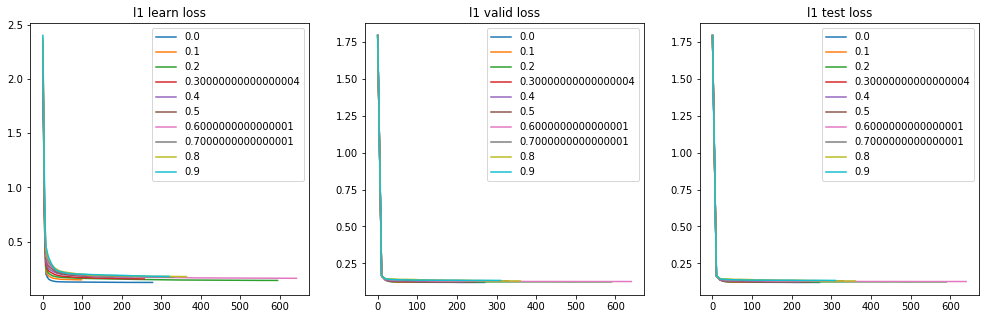

In [13]:
#learn
plt.figure(figsize=(17,5))

plt.subplot(1, 3, 1)
for num, lamb in enumerate(lambda_list):
    plt.plot(learn_loss_by_lambda[num], label=str(lamb))
plt.title('l1 learn loss')
plt.legend()

#valid
plt.subplot(1, 3, 2)
for num, lamb in enumerate(lambda_list):
    plt.plot(epoch_by_lambda[num], valid_loss_by_lambda[num], label=str(lamb))
plt.title('l1 valid loss')
plt.legend()

#test
plt.subplot(1, 3, 3)
for num, lamb in enumerate(lambda_list):
    plt.plot(epoch_by_lambda[num], test_loss_by_lambda[num], label=str(lamb))
plt.title('l1 test loss')
plt.legend()
plt.savefig('regul/l1_lossssss.png', bbox_inches='tight')

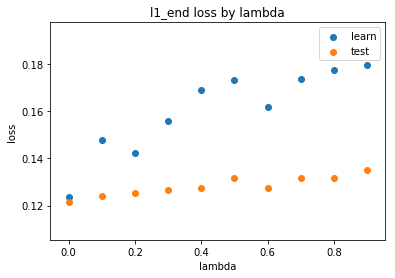

In [14]:
plt.scatter(lambda_list, end_learn_loss_by_lambda, label='learn')
plt.scatter(lambda_list, end_test_loss_by_lambda, label='test')
plt.xlabel('lambda')
plt.ylabel('loss')
plt.legend()
plt.title('l1_end loss by lambda')
plt.savefig('regul/l1_end_loss_by_lambda.png', bbox_inches='tight')

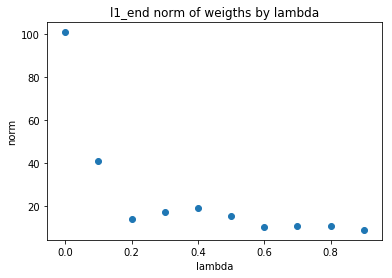

In [15]:
plt.scatter(lambda_list, end_norm_w_by_lambda)
plt.xlabel('lambda')
plt.ylabel('norm')
plt.title('l1_end norm of weigths by lambda')
plt.savefig('regul/l1_end_norm_of_weigths_by_lambda.png', bbox_inches='tight')

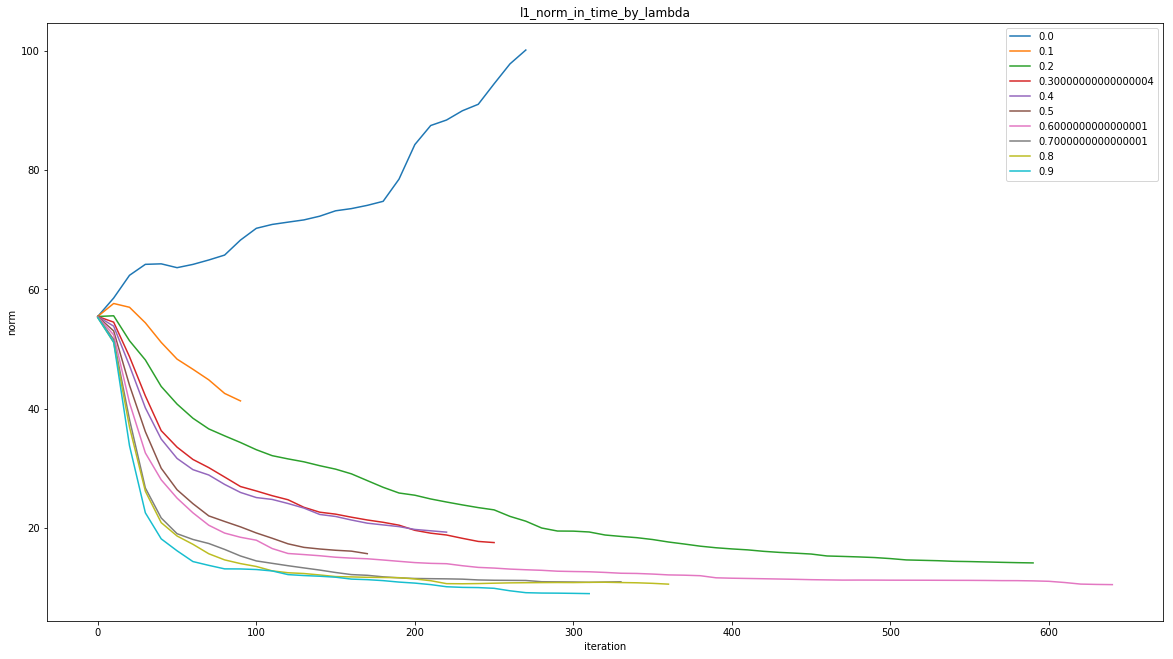

In [16]:
plt.figure(figsize=(20,11))
for num, norm_series in enumerate(norm_in_time_by_lambda):
    plt.plot(epoch_by_lambda[num], norm_series, label=str(lambda_list[num]))
plt.xlabel('iteration')
plt.ylabel('norm')
plt.title('l1_norm_in_time_by_lambda')
plt.legend()
plt.savefig('regul/l1_norm_in_time_by_lambda.png', bbox_inches='tight')

In [17]:
def reg_loss_l2(criterion, model, outputs, labels, lamb):
    l2_reg = torch.tensor(0.)
    for param in model.parameters():
        l2_reg += torch.norm(param)**2
    
    l2_reg = l2_reg/(2*amount_of_params)
    loss = criterion(outputs, labels)
    loss.add_(alpha = float(lamb), other = l2_reg)
    return loss

In [18]:
%%time
#l2

lambda_list = np.arange(0.0, 1.0, 0.1).tolist()

end_learn_loss_by_lambda = []
end_test_loss_by_lambda = []

end_norm_w_by_lambda = []

norm_in_time_by_lambda = []

learn_loss_by_lambda = []
valid_loss_by_lambda = []
test_loss_by_lambda = []
epoch_by_lambda = []

for lamb in lambda_list:
    optimizer = optim.Adam(net.parameters())
    
    tmp_null_weigth = list(null_weigth)
    net.apply(init_weigths)
    
    norm_in_time = []
    learn_epoch_loss = []
    valid_epoch_loss = []
    test_epoch_loss = []
    epoch_list = []
    
    for epoch in range(5000):
        loss_acc = []
        for learn_data in learn_dataloader:
            optimizer.zero_grad()
            features, labels = learn_data[:, FEATURES_INDEX].float(), learn_data[:, LABELS_INDEX].float()
            features.requres_grad = True
            labels.requres_grad = True
            
            outputs = net(features).squeeze()
            
            loss = reg_loss_l2(criterion, net, outputs, labels, lamb)
            
            loss.backward()
            optimizer.step()
            loss_acc.append(float(loss.data))
        learn_epoch_loss.append(np.mean(loss_acc))
        
        #критерий останова
        if (epoch > 10) and\
        (abs(learn_epoch_loss[len(learn_epoch_loss) - 1] - learn_epoch_loss[len(learn_epoch_loss) - 2]) < LOSS_THRESHOLD):
            print(learn_epoch_loss[len(learn_epoch_loss) - 1] - learn_epoch_loss[len(learn_epoch_loss) - 2])
            print('lambda: ', lamb, ' breaked on epoch: ', epoch, '\n')
            break
            
        if epoch % 50 == 0:
            epoch_list.append(epoch)
            for valid_data in valid_dataloader:
                features, labels = valid_data[:, FEATURES_INDEX].float(), valid_data[:, LABELS_INDEX].float()
                outputs = net(features).squeeze()
                loss = criterion(outputs, labels)
                valid_epoch_loss.append(float(loss.data))
                
            for test_data in valid_dataloader:
                features, labels = test_data[:, FEATURES_INDEX].float(), test_data[:, LABELS_INDEX].float()
                outputs = net(features).squeeze()
                loss = criterion(outputs, labels)
                test_epoch_loss.append(float(loss.data))
            
            norm = 0
            for param in net.parameters():
                norm += float(torch.norm(param))**2
            norm_in_time.append(norm)
            
    learn_loss_by_lambda.append(learn_epoch_loss)
    valid_loss_by_lambda.append(valid_epoch_loss)
    test_loss_by_lambda.append(test_epoch_loss)
    epoch_by_lambda.append(epoch_list)
    
    end_learn_loss_by_lambda.append(learn_epoch_loss[-1])
    end_test_loss_by_lambda.append(test_epoch_loss[-1])
    
    norm = 0
    for param in net.parameters():
        norm += float(torch.norm(param))**2
    end_norm_w_by_lambda.append(norm)
    
    norm_in_time_by_lambda.append(norm_in_time)
          

-9.238719940185547e-07
lambda:  0.0  breaked on epoch:  1623 

-9.834766387939453e-07
lambda:  0.1  breaked on epoch:  2046 

-9.5367431640625e-07
lambda:  0.2  breaked on epoch:  3827 

-9.98377799987793e-07
lambda:  0.30000000000000004  breaked on epoch:  4655 

-9.685754776000977e-07
lambda:  0.4  breaked on epoch:  4933 

-9.5367431640625e-07
lambda:  0.5  breaked on epoch:  4989 

-8.195638656616211e-07
lambda:  0.6000000000000001  breaked on epoch:  4969 

CPU times: user 25min 54s, sys: 23.4 s, total: 26min 17s
Wall time: 20min 53s


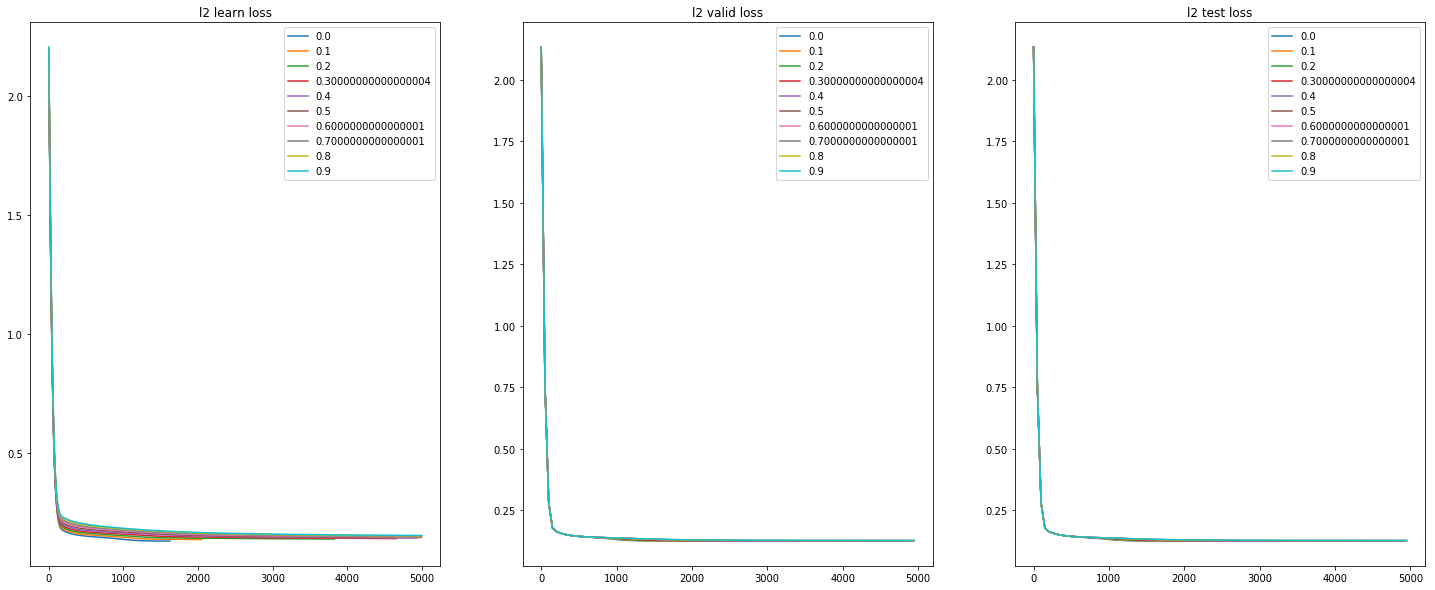

In [19]:
#learn
plt.figure(figsize=(25,10))

plt.subplot(1, 3, 1)
for num, lamb in enumerate(lambda_list):
    plt.plot(learn_loss_by_lambda[num], label=str(lamb))
plt.title('l2 learn loss')
plt.legend()

#valid
plt.subplot(1, 3, 2)
for num, lamb in enumerate(lambda_list):
    plt.plot(epoch_by_lambda[num], valid_loss_by_lambda[num], label=str(lamb))
plt.title('l2 valid loss')
plt.legend()

#test
plt.subplot(1, 3, 3)
for num, lamb in enumerate(lambda_list):
    plt.plot(epoch_by_lambda[num], test_loss_by_lambda[num], label=str(lamb))
plt.title('l2 test loss')
plt.legend()
plt.savefig('regul/l2_lossssss.png', bbox_inches='tight')

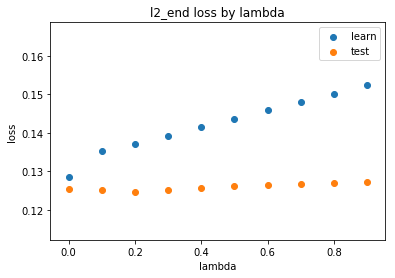

In [20]:
plt.scatter(lambda_list, end_learn_loss_by_lambda, label='learn')
plt.scatter(lambda_list, end_test_loss_by_lambda, label='test')
plt.xlabel('lambda')
plt.ylabel('loss')
plt.legend()
plt.title('l2_end loss by lambda')
plt.savefig('regul/l2_end_loss_by_lambda.png', bbox_inches='tight')

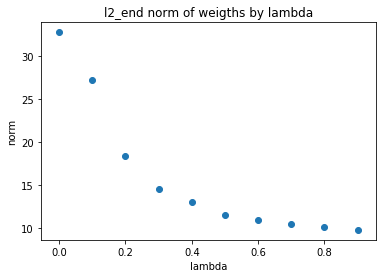

In [21]:
plt.scatter(lambda_list, end_norm_w_by_lambda)
plt.xlabel('lambda')
plt.ylabel('norm')
plt.title('l2_end norm of weigths by lambda')
plt.savefig('regul/l2_end_norm_of_weigths_by_lambda.png', bbox_inches='tight')

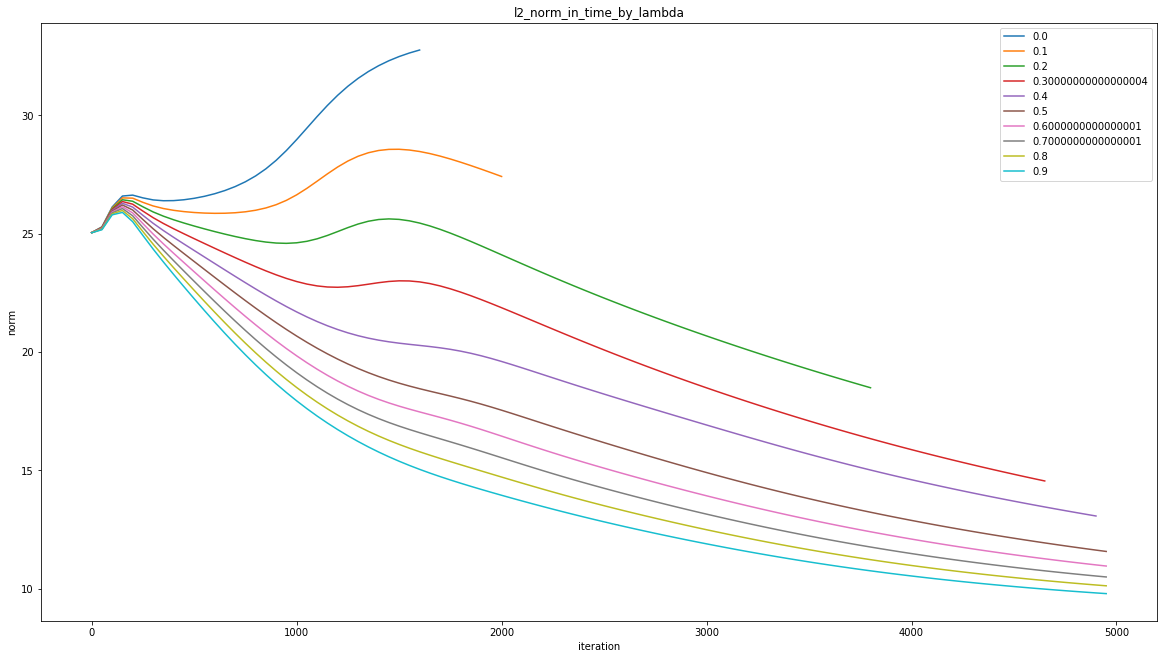

In [22]:
plt.figure(figsize=(20,11))
for num, norm_series in enumerate(norm_in_time_by_lambda):
    plt.plot(epoch_by_lambda[num], norm_series, label=str(lambda_list[num]))
plt.xlabel('iteration')
plt.ylabel('norm')
plt.title('l2_norm_in_time_by_lambda')
plt.legend()
plt.savefig('regul/l2_norm_in_time_by_lambda.png', bbox_inches='tight')